# Frekvenčna analiza samoglasnikov z uporabo skalarnega produkta

V tej nalogi analiziramo frekvenčno vsebino izgovorjenih samoglasnikov "a", "i", "o" z uporabo skalarnega produkta. Uporabimo tako realne kot kompleksne sinusoide, primerjamo rezultate s hitro Fourierjevo transformacijo (FFT), in določimo pomembne frekvence vsakega signala.


In [13]:
import numpy as np
from frequency_analysis import real_scalar_product, complex_scalar_product
from utils import load_audio, trim_signal, compute_fft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import sounddevice as sd
import librosa
import soundfile as sf




In [3]:
def analyze_vowel(vowel, duration=0.5, N=2000):
    print(f"Processing vowel: {vowel}")
    path = f"audio_data/{vowel}_2_trimmed.wav"
    rate, signal = load_audio(path)
    signal = trim_signal(signal, rate, duration)

    # FFT
    fft_freqs, fft_mag = compute_fft(signal, rate)
    mask = fft_freqs <= N
    fft_freqs = fft_freqs[mask]
    fft_mag = fft_mag[mask]
    plot_spectrum(fft_freqs, fft_mag, f"{vowel.upper()} - FFT Spectrum")

    # Frequencies for scalar products
    freq_resolution = 1 / duration
    freqs = np.arange(0, min(N, rate / 2) + freq_resolution, freq_resolution)

    # Real sinusoids
    real_mag = real_scalar_product(signal, rate, freqs)
    plot_spectrum(freqs, real_mag, f"{vowel.upper()} - Real Scalar Product")

    # Complex sinusoids
    complex_mag = complex_scalar_product(signal, rate, freqs)
    plot_spectrum(freqs, complex_mag, f"{vowel.upper()} - Complex Scalar Product")

    # Energy threshold
    total_energy = np.sum(complex_mag ** 2)
    threshold = 0.01 * total_energy
    significant_freqs = freqs[complex_mag ** 2 >= threshold]

    print(f"Significant frequencies for '{vowel}' (≥1% energy):")
    print(significant_freqs)


def plot_spectrum(freqs, magnitudes, title):
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, magnitudes)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (Scalar Product)')
    plt.grid(True)
    plt.xlim(0, max(freqs))
    plt.tight_layout()
    plt.show()

Processing vowel: a


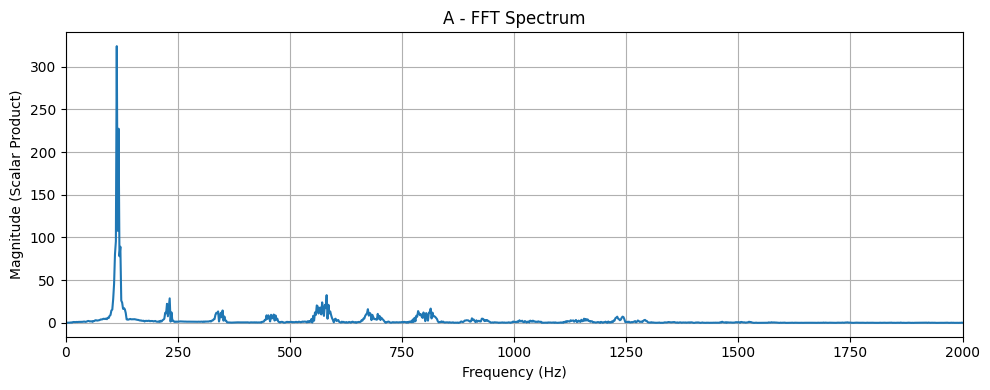

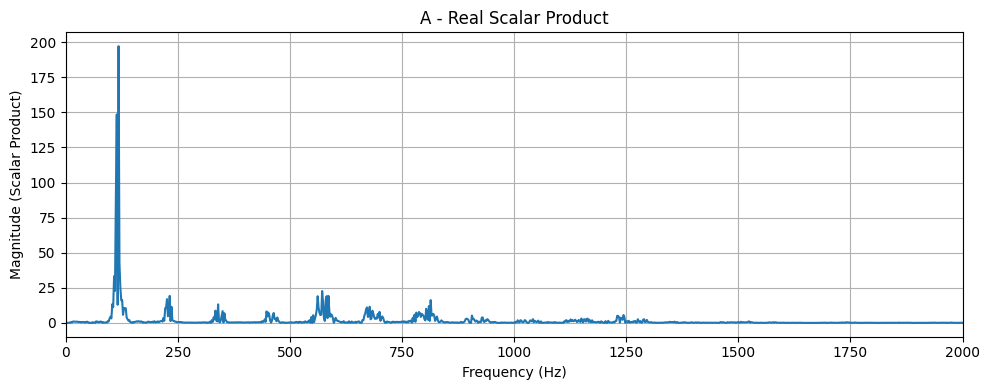

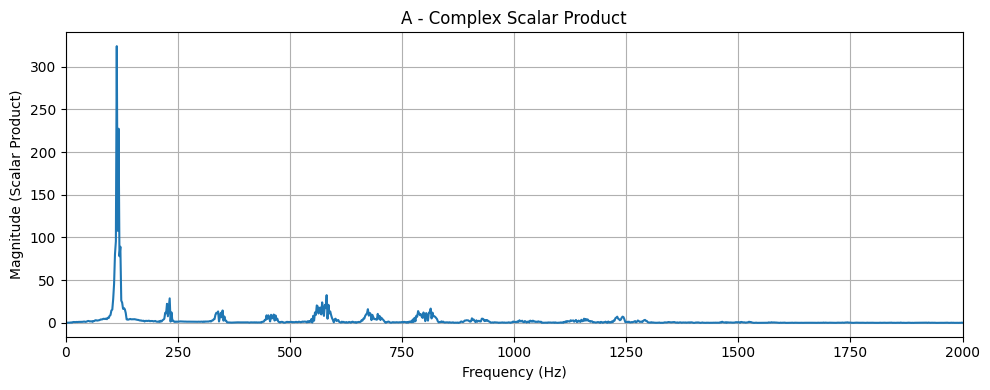

Significant frequencies for 'a' (≥1% energy):
[110. 112. 114. 116. 118. 120. 122.]


In [4]:
analyze_vowel('a')

Processing vowel: i


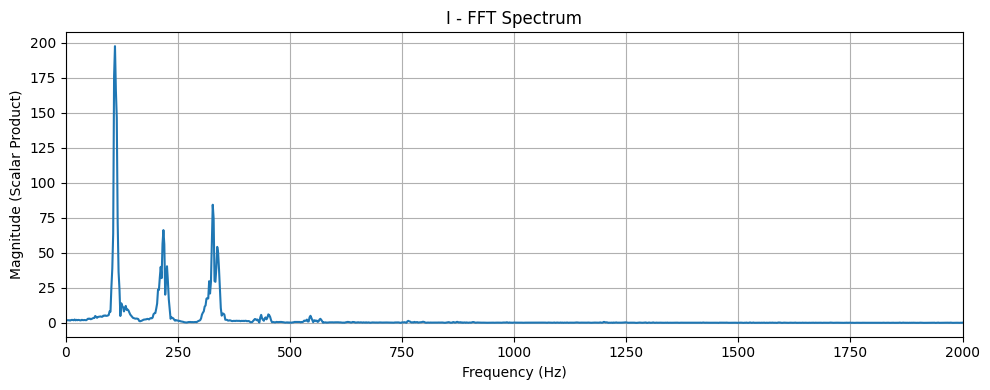

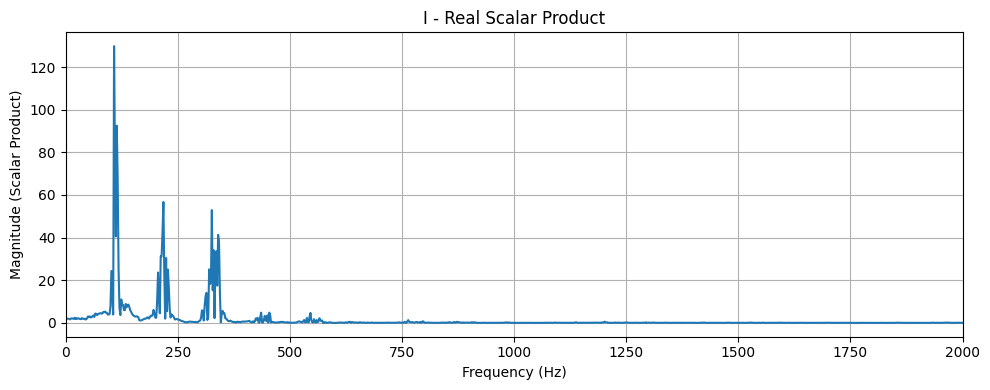

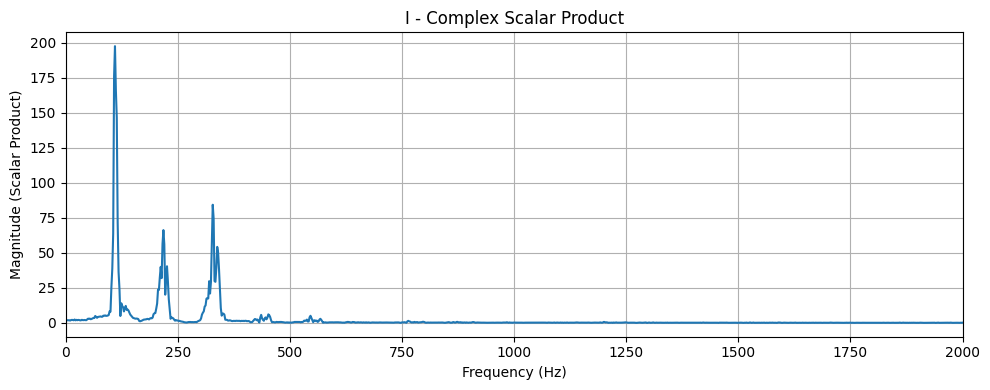

Significant frequencies for 'i' (≥1% energy):
[106. 108. 110. 112. 114. 116. 216. 218. 220. 326. 328. 330. 338. 340.]


In [5]:
analyze_vowel('i')

Processing vowel: o


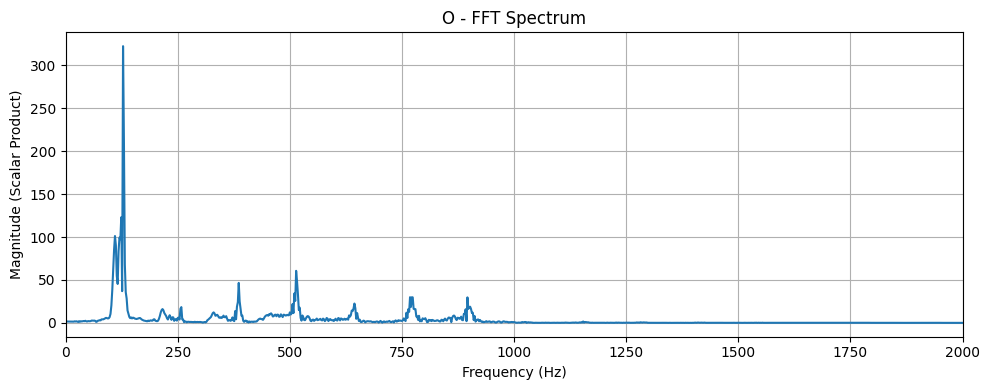

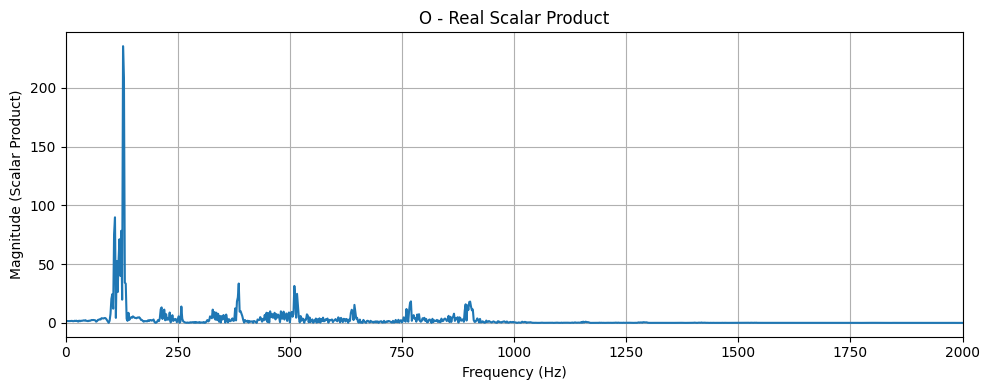

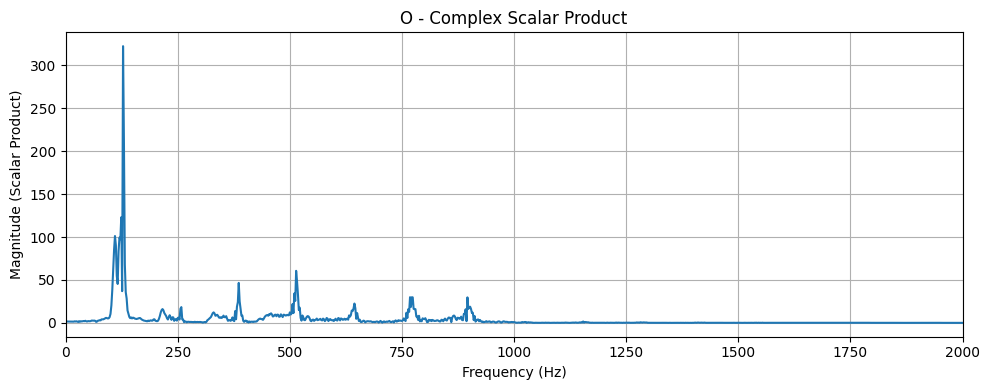

Significant frequencies for 'o' (≥1% energy):
[106. 108. 110. 112. 114. 118. 120. 122. 124. 128. 130. 132. 514.]


In [6]:
analyze_vowel('o')


### 1. Ali lahko frekvenčno sliko signala nedvoumno določimo preko skalarnega produkta med posnetim signalom in izbrano realno sinusoido? Zakaj?

Ne, frekvenčne slike ne moremo nedvoumno določiti z realno sinusoido, saj ta ne loči med pozitivnimi in negativnimi frekvencami. Poleg tega zajame le realni del frekvenčne komponente, zato izgubimo informacijo o fazi in lahko podcenimo energijo. Za popolno frekvenčno sliko potrebujemo projekcijo na kompleksne eksponente, kot pri Fourierjevi transformaciji.


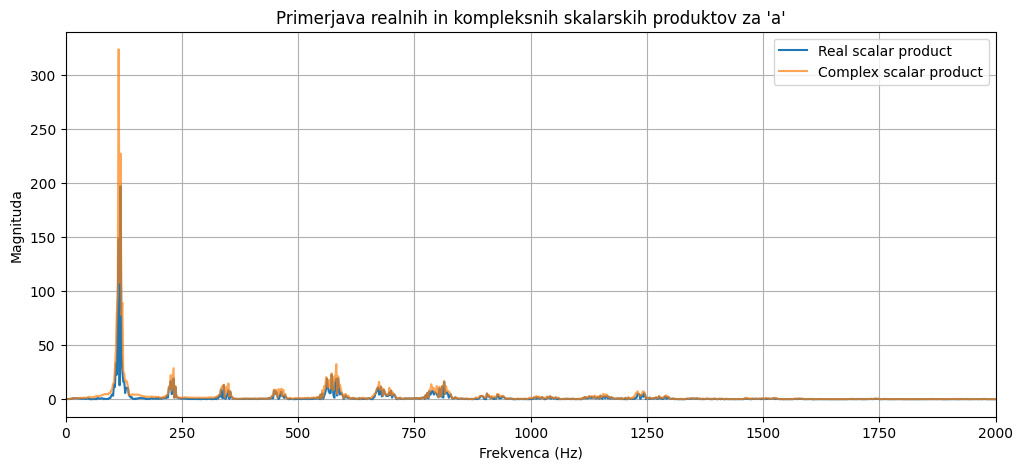

In [7]:
vowel = 'a'
duration = 0.5
N = 2000

rate, signal = load_audio(f"audio_data/{vowel}_2_trimmed.wav")
signal = trim_signal(signal, rate, duration)

freq_resolution = 1 / duration
freqs = np.arange(0, min(N, rate / 2) + freq_resolution, freq_resolution)

real_mag = real_scalar_product(signal, rate, freqs)
complex_mag = complex_scalar_product(signal, rate, freqs)

plt.figure(figsize=(12,5))
plt.plot(freqs, real_mag, label='Real scalar product')
plt.plot(freqs, complex_mag, label='Complex scalar product', alpha=0.7)
plt.title(f"Primerjava realnih in kompleksnih skalarskih produktov za '{vowel}'")
plt.xlabel("Frekvenca (Hz)")
plt.ylabel("Magnituda")
plt.legend()
plt.grid(True)
plt.xlim(0, N)
plt.show()


### 2. Ali lahko frekvenčno sliko signala nedvoumno določimo preko skalarnega produkta med posnetim signalom in izbrano kompleksno sinusoido? Kako na to vpliva dolžina opazovanega intervala signala? Zakaj?

Da, preko kompleksnih sinusoid lahko določimo nedvoumno frekvenčno sliko, saj kompleksne sinusoide vsebujejo fazno informacijo, ki loči pozitivne od negativnih frekvenc.

Dolžina opazovanega intervala signala vpliva na frekvenčno resolucijo: daljši interval omogoča boljšo ločljivost frekvenc (manjši frekvenčni korak), medtem ko krajši interval povzroči širjenje spektra zaradi efektov diskretizacije in omejene resolucije (*spectral leakage*).

To lahko opazujemo na primerjavi rezultatov za različna trajanja signala.


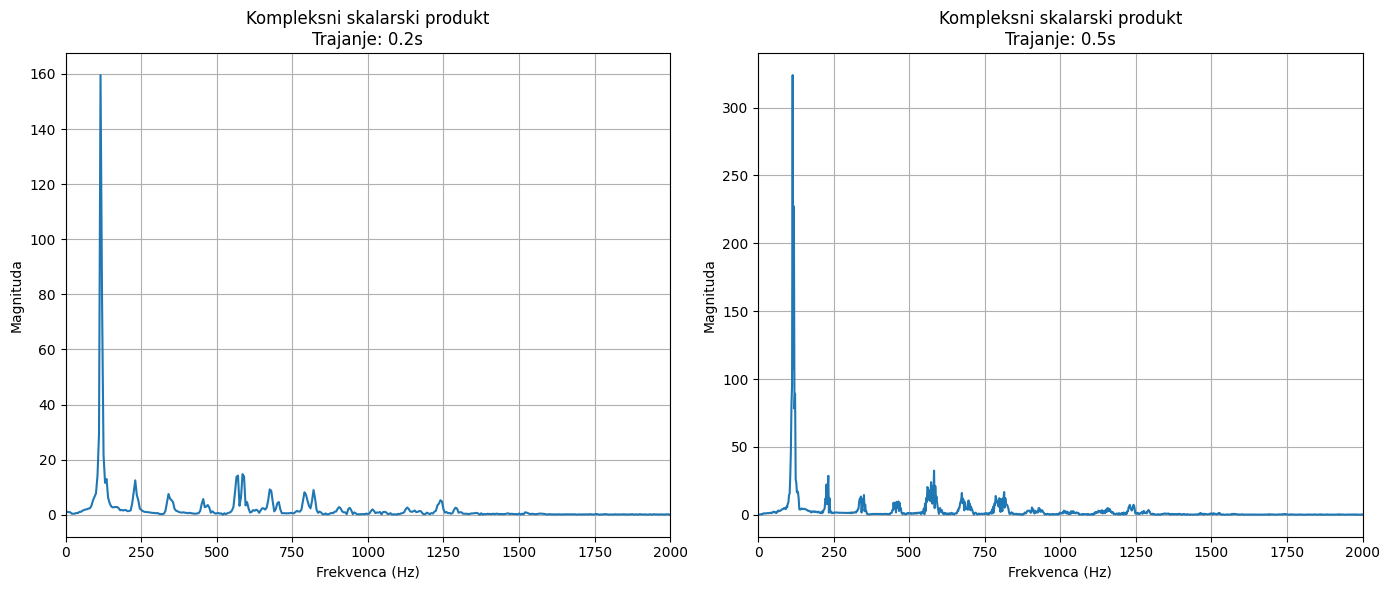

In [10]:
vowel = 'a'
durations = [0.2, 0.5]
N = 2000

plt.figure(figsize=(14,6))

for i, duration in enumerate(durations):
    rate, signal = load_audio(f"audio_data/{vowel}_2_trimmed.wav")
    signal = trim_signal(signal, rate, duration)
    freq_resolution = 1 / duration
    freqs = np.arange(0, min(N, rate / 2) + freq_resolution, freq_resolution)
    complex_mag = complex_scalar_product(signal, rate, freqs)

    plt.subplot(1, 2, i+1)
    plt.plot(freqs, complex_mag)
    plt.title(f"Kompleksni skalarski produkt\nTrajanje: {duration}s")
    plt.xlabel("Frekvenca (Hz)")
    plt.ylabel("Magnituda")
    plt.grid(True)
    plt.xlim(0, N)

plt.tight_layout()
plt.show()


### 3. Katere vse frekvence so prisotne v izgovorjavi samoglasnikov »a«, »i« in »o« (osredotočite se na frekvence, ki predstavljajo vsaj 1 % celotne energije signala)?

Pomembne frekvence so tiste, katerih kvadrat magnitude skalarskega produkta (energija) predstavlja vsaj 1 % celotne energije signala.  
To so t.i. formanti samoglasnikov in osnovni toni, ki karakterizirajo njihovo zvočno barvo.

Spodaj izpišemo pomembne frekvence za vse tri samoglasnike.


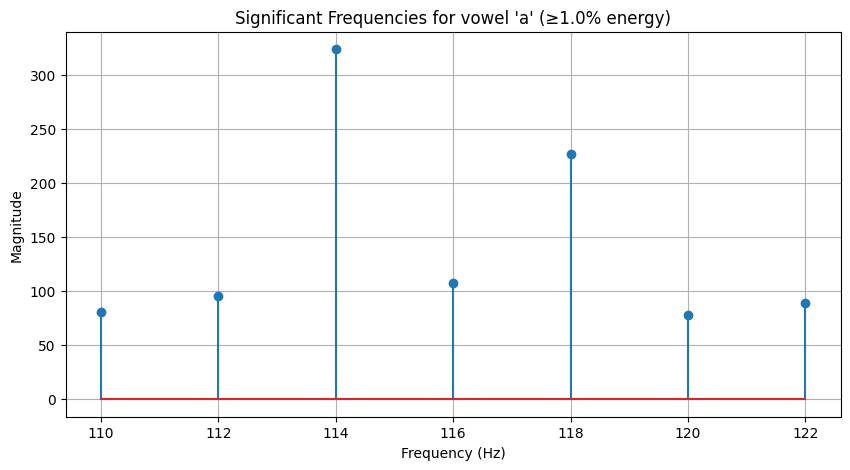

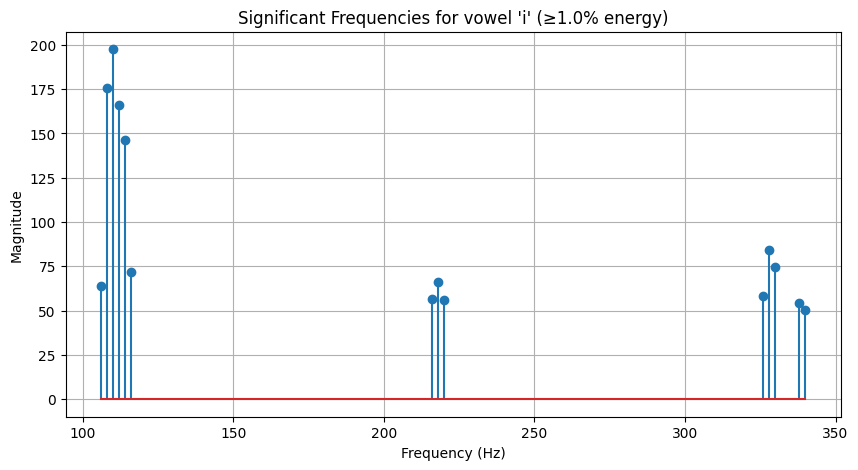

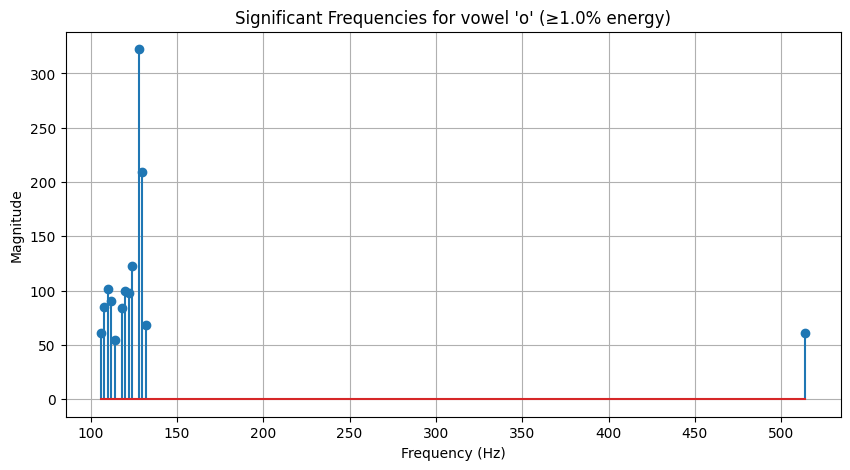

In [9]:

def plot_significant_freqs(vowel, duration=0.5, N=2000, energy_threshold=0.01):
    rate, signal = load_audio(f"audio_data/{vowel}_2_trimmed.wav")
    signal = trim_signal(signal, rate, duration)
    freq_resolution = 1 / duration
    freqs = np.arange(0, min(N, rate / 2) + freq_resolution, freq_resolution)
    complex_mag = complex_scalar_product(signal, rate, freqs)
    
    total_energy = np.sum(complex_mag ** 2)
    threshold = energy_threshold * total_energy
    
    mask = complex_mag ** 2 >= threshold
    significant_freqs = freqs[mask]
    significant_mags = complex_mag[mask]
    
    plt.figure(figsize=(10, 5))
    plt.stem(significant_freqs, significant_mags)  # Removed use_line_collection argument
    plt.title(f"Significant Frequencies for vowel '{vowel}' (≥{energy_threshold*100}% energy)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

for vowel in ['a', 'i', 'o']:
    plot_significant_freqs(vowel)

### 4. Kako so frekvence, ki so prisotne v izgovorjavi samoglasnikov »a«, »i« in »o«, odvisne od višine tona izgovorjave?

Višina tona vpliva na osnovno frekvenco (fundamental), ki se kaže kot najnižji vrh v frekvenčni sliki.  
Višji toni pomenijo višjo osnovno frekvenco, ki premika tudi višje harmonike.  
Frekvence formantov pa so predvsem odvisne od fizioloških značilnosti govorca in samoglasnika.


### 5. Kako se z višino tona izgovorjave spremeni pojav višjih harmonikov v frekvenčni sliki?

Z višjo višino tona se osnovna frekvenca in s tem višji harmoniki premaknejo proti višjim frekvencam.  
To pomeni, da se v frekvenčni sliki pojavijo vrhovi na višjih frekvencah, ki so večkratniki osnovne frekvence.  
Pri analizi več posnetkov z različnimi višinskimi toni lahko opazimo te premike harmonikov.


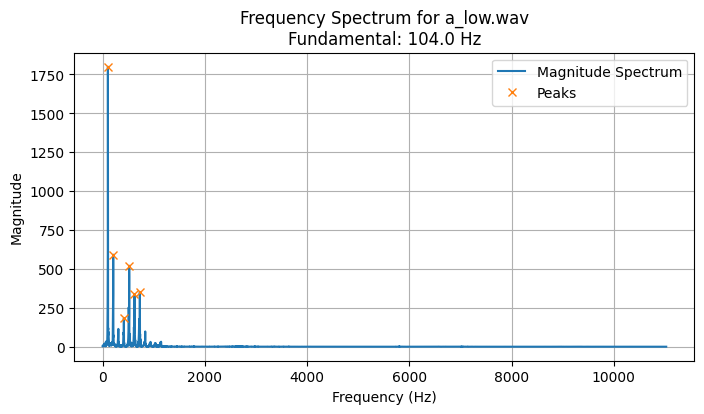

Vowel 'a', pitch 'low': Fundamental frequency ≈ 104.0 Hz


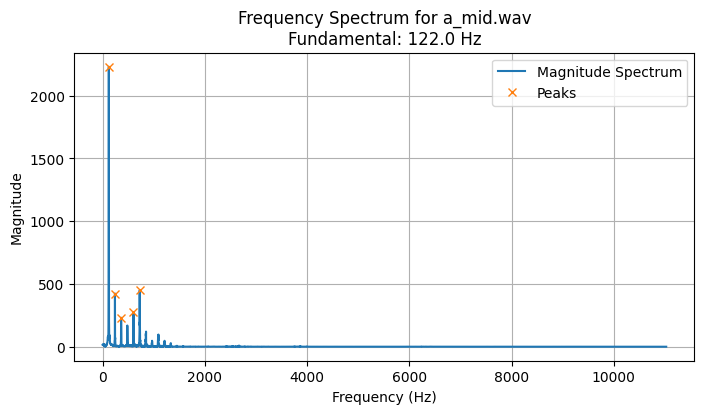

Vowel 'a', pitch 'mid': Fundamental frequency ≈ 122.0 Hz


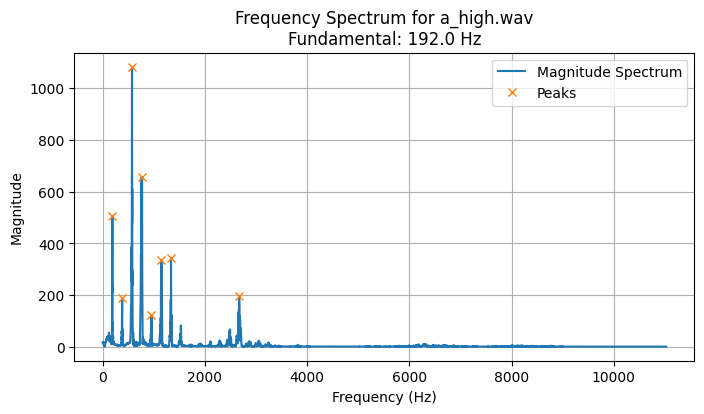

Vowel 'a', pitch 'high': Fundamental frequency ≈ 192.0 Hz


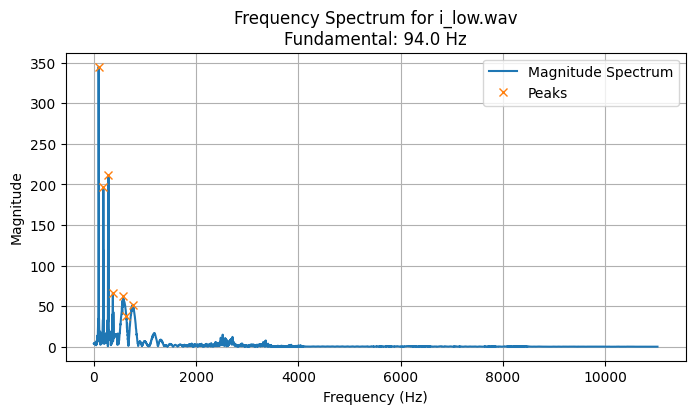

Vowel 'i', pitch 'low': Fundamental frequency ≈ 94.0 Hz


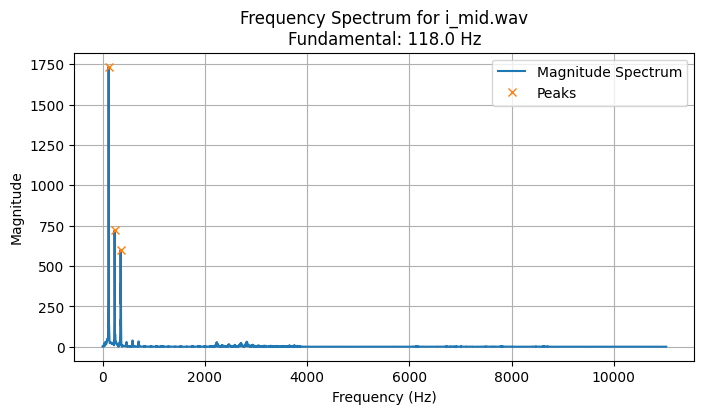

Vowel 'i', pitch 'mid': Fundamental frequency ≈ 118.0 Hz


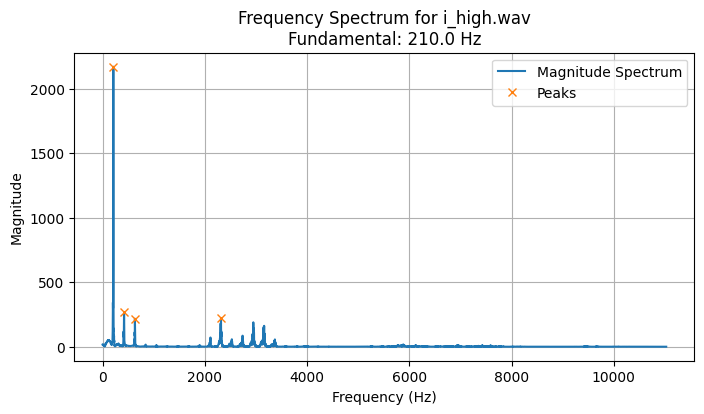

Vowel 'i', pitch 'high': Fundamental frequency ≈ 210.0 Hz


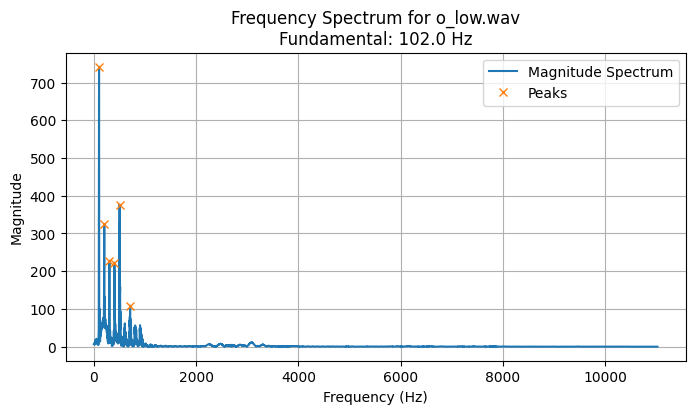

Vowel 'o', pitch 'low': Fundamental frequency ≈ 102.0 Hz


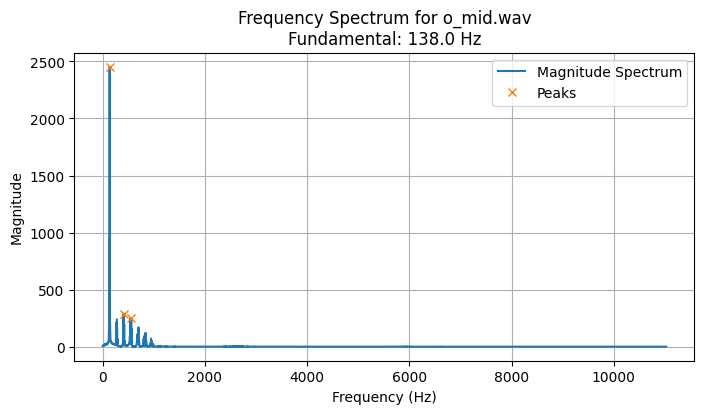

Vowel 'o', pitch 'mid': Fundamental frequency ≈ 138.0 Hz


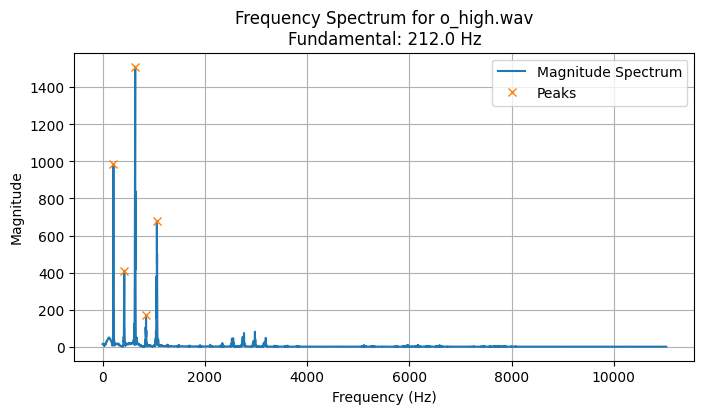

Vowel 'o', pitch 'high': Fundamental frequency ≈ 212.0 Hz


In [14]:

def analyze_recording(filename, duration=0.5, plot=True):
    signal, fs = sf.read(filename)
    N = len(signal)

    fft_result = np.fft.rfft(signal)
    mag = np.abs(fft_result)
    freqs = np.fft.rfftfreq(N, 1/fs)

    peaks, properties = find_peaks(mag, height=np.max(mag)*0.1, distance=20)

    fundamental_freq = freqs[peaks[0]] if len(peaks) > 0 else None

    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(freqs, mag, label='Magnitude Spectrum')
        plt.plot(freqs[peaks], mag[peaks], "x", label='Peaks')
        plt.title(f"Frequency Spectrum for {os.path.basename(filename)}\nFundamental: {fundamental_freq:.1f} Hz")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.legend()
        plt.show()

    return fundamental_freq, freqs[peaks], mag[peaks]

vowels = ['a', 'i', 'o']
pitch_labels = ['low', 'mid', 'high']
base_dir = 'recordings'

results = {}

for vowel in vowels:
    results[vowel] = {}
    for pitch in pitch_labels:
        filepath = os.path.join(base_dir, vowel, f"{vowel}_{pitch}.wav")
        if os.path.isfile(filepath):
            fundamental, peak_freqs, peak_mags = analyze_recording(filepath)
            results[vowel][pitch] = {
                'fundamental_freq': fundamental,
                'peak_freqs': peak_freqs,
                'peak_mags': peak_mags
            }
            print(f"Vowel '{vowel}', pitch '{pitch}': Fundamental frequency ≈ {fundamental:.1f} Hz")
        else:
            print(f"File not found: {filepath}")